In [7]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [8]:
quantiles = [round(q/1000, 2) for q in range(1, 999, 10)][1:]
print(quantiles)

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]


### Training

In [9]:
input_filename = 'xy_2020-07-11.csv'
training_df = pd.read_csv(f'data/{input_filename}')

QR_MODEL = smf.quantreg('y ~ x', training_df)

def fit_qr_model_to(quantile):
    result = QR_MODEL.fit(q=quantile, max_iter=10000)
    alpha = result.params['Intercept']
    beta  = result.params['x']
    return alpha, beta

models_per_quantile = {
    quantile: fit_qr_model_to(quantile) 
    for quantile in quantiles
}

### Prediction

In [10]:
predictions = []
x_vals = np.arange(training_df.x.min(), training_df.x.max())
for x in x_vals:
    for quantile in quantiles:
        alpha, beta = models_per_quantile[quantile]
        y_predicted = alpha + (beta * x)
        predictions.append([x, quantile, y_predicted])

predictions_df = pd.DataFrame(
    predictions, 
    columns=['x', 'quantile', 'y_predicted'],
)

### Output

In [11]:
predictions_df.head(5)

,x,quantile,y_predicted
0,1,0.01,-0.001786
1,1,0.02,0.002963
2,1,0.03,0.002393
3,1,0.04,0.006048
4,1,0.05,0.006974


In [12]:
predictions_df_pivoted_by_quantiles = predictions_df.pivot(
    index='x', columns='quantile',
)

In [13]:
predictions_df_pivoted_by_quantiles.head(5)

y_predicted                                                    \
quantile        0.01      0.02      0.03      0.04      0.05      0.06   
x                                                                        
1          -0.001786  0.002963  0.002393  0.006048  0.006974  0.008569   
2          -0.001703  0.003000  0.002460  0.006069  0.006991  0.008562   
3          -0.001619  0.003037  0.002528  0.006091  0.007009  0.008556   
4          -0.001536  0.003074  0.002595  0.006112  0.007026  0.008549   
5          -0.001452  0.003111  0.002662  0.006133  0.007044  0.008542   

                                                  ...                      \
quantile      0.07      0.08      0.09      0.10  ...      0.90      0.91   
x                                                 ...                       
1         0.015392  0.017436  0.017694  0.021362  ...  0.091733  0.092339   
2         0.015307  0.017331  0.017646  0.021282  ...  0.094123  0.094819   
3         0.015222  0.017226  0.017597  0.021201  ...  0.096512  0.097300   
4         0.015137  0.017121  0.017549  0.021121  ...  0.098901  0.099781   
5         0.015052  0.017016  0.017501  0.021041  ...  0.101290  0.102261   

                                                                      \
quantile      0.92      0.93      0.94      0.95      0.96      0.97   
x                                                                      
1         0.092600  0.108163  0.111397  0.111700  0.124307  0.138520   
2         0.095132  0.110518  0.113776  0.114120  0.126608  0.140734   
3         0.097663  0.112873  0.116154  0.116539  0.128909  0.142947   
4         0.100194  0.115228  0.118533  0.118959  0.131210  0.145160   
5         0.102725  0.117583  0.120911  0.121378  0.133511  0.147374   

                              
quantile      0.98      0.99  
x                             
1         0.137437  0.167982  
2         0.139761  0.169963  
3         0.142085  0.171944  
4         0.144409  0.173925  
5         0.146733  0.175906  

[5 rows x 99 columns]

In [14]:
predictions_df.to_csv(f'data/{input_filename}_predictions.csv', index=False)

In [15]:
predictions_df_pivoted_by_quantiles.to_csv(
    f'data/{input_filename}_predictions_pivoted.csv', 
)

### Visualization
Plot the modeled curve (line) for a particular quantile with the backdrop of the original data.

In [16]:
# TODO: Set this to what you want to visualize!
QUANTILE_TO_VISUAIZE  = 0.95  

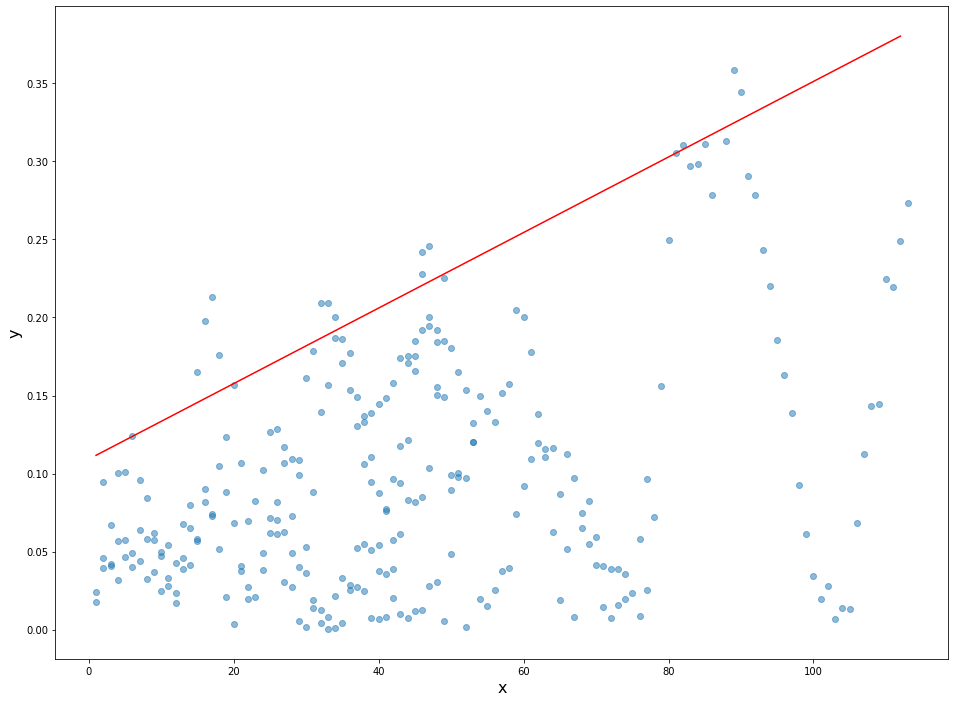

In [17]:
fig, ax = plt.subplots(figsize=(16, 12))

# plot traing data
ax.scatter(training_df.x, training_df.y, alpha=0.5)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16,);

# plot curve modeled by using QR for QUANTILE_TO_VISUAIZE
predictions_for_given_q =  predictions_df.query(
    f'quantile == {QUANTILE_TO_VISUAIZE}'
)
x_vals = predictions_for_given_q.x
y_vals = predictions_for_given_q.y_predicted
ax.plot(x_vals, y_vals, linestyle='solid', color='red')